# pqm

> Pixel Quality Metrics

In [ ]:
#| default_exp pqm

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
import numpy as np
import zarr
import moraine as mr
from moraine.utils_ import is_cuda_available
if is_cuda_available():
    import cupy as cp
from matplotlib import pyplot as plt

In [ ]:
#| export
import numpy as np
import moraine as mr
from moraine.utils_ import is_cuda_available, get_array_module
if is_cuda_available():
    import cupy as cp
from numba import prange
from moraine.utils_ import ngpjit

In [ ]:
#| export
# @ngpjit
# def _temp_coh_pc_numba(
#     intf:np.ndarray,# complex interferograms/coherence metrix, dtype np.complex64
#     rslc:np.ndarray, # complex rslc/phase history, dtype np.complex64
#     image_pairs:np.ndarray, # image pairs
# ):
#     nimages = rslc.shape[-1]
#     n_points = rslc.shape[0]
#     n_image_pairs = image_pairs.shape[0]
#     temp_coh = np.empty(n_points,dtype=np.float32)
#     for i in prange(n_points):
#         rslc_ = rslc[i]
#         intf_ = intf[i]
#         for j in range(nimages):
#             rslc_[j] = rslc_[j]/abs(rslc_[j])
#         for j in range(n_image_pairs):
#             intf_[j] = intf_[j]/abs(intf_[j])
#         _t_coh = np.float32(0.0)
#         for j in range(n_image_pairs):
#             n, k = image_pairs[j,0],image_pairs[j,1]
#             rslc_intf_ = np.conjugate(rslc_[n])*rslc_[k]
#             diff_ph = intf_[j]*rslc_intf_
#             _t_coh += diff_ph.real
#         _t_coh = _t_coh/n_image_pairs
#         temp_coh[i] = _t_coh
#     return temp_coh

In [ ]:
#| export
@ngpjit
def _temp_coh_pc_numba(
    intf:np.ndarray,# complex interferograms/coherence metrix, dtype np.complex64
    rslc:np.ndarray, # complex rslc/phase history, dtype np.complex64
    image_pairs:np.ndarray, # image pairs
):
    nimages = rslc.shape[-1]
    n_points = rslc.shape[0]
    n_image_pairs = image_pairs.shape[0]
    temp_coh = np.empty(n_points,dtype=np.float32)
    for i in prange(n_points):
        rslc_ = rslc[i]
        intf_ = intf[i]
        for j in range(nimages):
            rslc_[j] = rslc_[j]/abs(rslc_[j])
        for j in range(n_image_pairs):
            intf_[j] = intf_[j]/abs(intf_[j])
        _t_coh = np.complex64(0.0)
        for j in range(n_image_pairs):
            n, k = image_pairs[j,0],image_pairs[j,1]
            rslc_intf_ = np.conjugate(rslc_[n])*rslc_[k]
            diff_ph = intf_[j]*rslc_intf_
            _t_coh += diff_ph
        _t_coh = np.abs(_t_coh)/n_image_pairs
        temp_coh[i] = _t_coh
    return temp_coh

In [ ]:
#| export
# if is_cuda_available():
#     _temp_coh_pc_kernel = cp.ElementwiseKernel(
#         'raw T intf, raw T rslc, raw I image_pairs, int32 n_points, int32 nimages, int32 n_image_pairs',
#         'raw float32 temp_coh',
#         '''
#         if (i >= n_points) return;
#         float t_coh_ = 0;
#         int j; int n; int k;
#         int intf_idx; int rslc_n_idx; int rslc_k_idx;
#         float norm_factor = 0;
#         for (j = 0; j< n_image_pairs; j++){
#             n = image_pairs[j*2];
#             k = image_pairs[j*2+1];
#             intf_idx = i*n_image_pairs+j;
#             rslc_n_idx = i*nimages+n;
#             rslc_k_idx = i*nimages+k;
#             norm_factor = sqrt(norm(intf[intf_idx])*norm(rslc[rslc_n_idx])*norm(rslc[rslc_k_idx]));
#             t_coh_ += real(intf[intf_idx]*conj(rslc[rslc_n_idx])*rslc[rslc_k_idx]/norm_factor);
#         }
#         temp_coh[i] = t_coh_/n_image_pairs;
#         ''',
#         name = 'temp_coh_pc_kernel',no_return=True,
#     )

In [ ]:
#| export
if is_cuda_available():
    _temp_coh_pc_kernel = cp.ElementwiseKernel(
        'raw T intf, raw T rslc, raw I image_pairs, int32 n_points, int32 nimages, int32 n_image_pairs',
        'raw float32 temp_coh',
        '''
        if (i >= n_points) return;
        T t_coh_ = T(0.0,0.0);
        int j; int n; int k;
        int intf_idx; int rslc_n_idx; int rslc_k_idx;
        float norm_factor = 0;
        for (j = 0; j< n_image_pairs; j++){
            n = image_pairs[j*2];
            k = image_pairs[j*2+1];
            intf_idx = i*n_image_pairs+j;
            rslc_n_idx = i*nimages+n;
            rslc_k_idx = i*nimages+k;
            norm_factor = sqrt(norm(intf[intf_idx])*norm(rslc[rslc_n_idx])*norm(rslc[rslc_k_idx]));
            t_coh_ += intf[intf_idx]*conj(rslc[rslc_n_idx])*rslc[rslc_k_idx]/norm_factor;
        }
        temp_coh[i] = abs(t_coh_)/n_image_pairs;
        ''',
        name = 'temp_coh_pc_kernel',no_return=True,
    )

In [ ]:
#| export
def temp_coh(
    intf:np.ndarray,# complex interferograms/coherence metrix, dtype cp/np.complex64, shape 2D(pc) or 3D(ras)
    rslc:np.ndarray, # complex rslc/phase history, dtype cp/np.complex64, shape 2D(pc) or 3D(ras)
    image_pairs:np.ndarray=None, # image pairs
    block_size:int=128, # the CUDA block size, only applied for cuda
):
    '''Estimation of temporal coherence.'''
    xp = get_array_module(intf)
    assert intf.ndim == rslc.ndim
    if intf.ndim == 3:
        # convert to pc
        is_ras = True
        height, width = intf.shape[:2]
        n_points =height*width
        intf = intf.reshape((-1,intf.shape[-1]))
        rslc = rslc.reshape((-1,rslc.shape[-1]))
    elif intf.ndim == 2:
        is_ras = False
        n_points = rslc.shape[0]

    nimages = rslc.shape[-1]
    if image_pairs is None:
        image_pairs = mr.TempNet.from_bandwidth(nimages).image_pairs
    image_pairs = image_pairs.astype(np.int32)
    
    if xp is np:
        out_temp_coh = _temp_coh_pc_numba(intf,rslc,image_pairs)
    else:
        image_pairs = cp.asarray(image_pairs)
        n_image_pairs = image_pairs.shape[0]
        out_temp_coh = cp.empty(n_points, dtype=cp.float32)
        _temp_coh_pc_kernel(intf, rslc, image_pairs, cp.int32(n_points),cp.int32(nimages),cp.int32(n_image_pairs), out_temp_coh, size=n_points, block_size=block_size)

    if is_ras:
        out_temp_coh = out_temp_coh.reshape((height,width))
    return out_temp_coh

This function estimate the temporal coherence of as

$$\gamma = \frac{1}{N_{IP}} \left| \sum_{n, k \in IP} e^{i\phi_{nk}} e^{-i(\theta_n-\theta_k)} \right| $$

Where $\phi_{nk}$ is the phase of complex interferogram/coherence matrix, $\theta_{n}$ is the phase of rslc or phase after phase linking, $IP$ is the image pairs, $N_{IP}$ is the number of image pairs.

If all image pairs are considered, then it is:

$$\gamma = \frac{2}{N^2-N} \left| \sum_{n=1}^{N} \sum_{k=n+1}^{N} e^{i\phi_{nk}} e^{-i(\theta_n-\theta_k)} \right| $$

This function applies to both raster data and point cloud data, an example for pc data is the estimation of temporal coherence for distributed scatterers after phase linking:

In [ ]:
rslc = zarr.open('../../data/rslc.zarr/','r')[:]

# SHP selection
az_half_win = 5; r_half_win = 5
az_win = 2*az_half_win+1; r_win = 2*r_half_win+1

rmli = np.abs(rslc)**2
p = mr.ks_test(rmli,az_half_win=az_half_win,r_half_win=r_half_win)
is_shp = p < 0.05

# Select DS candidate
shp_num = np.count_nonzero(is_shp,axis=(-2,-1))
is_ds_can = shp_num >= 50

ds_can_is_shp = is_shp[is_ds_can]
ds_can_idx = np.stack(np.where(is_ds_can),axis=-1)
ds_can_coh = mr.emperical_co_pc(rslc,ds_can_idx,ds_can_is_shp)
ds_can_ph = mr.emi(ds_can_coh)[0]
print(ds_can_coh.shape,ds_can_ph.shape)

(732727, 136) (732727, 17)


In [ ]:
ds_can_temp_coh = temp_coh(ds_can_coh,ds_can_ph)
if is_cuda_available():
    ds_can_temp_coh_cp = temp_coh(cp.asarray(ds_can_coh), cp.asarray(ds_can_ph))
    np.testing.assert_array_almost_equal(ds_can_temp_coh, ds_can_temp_coh_cp.get())

In [ ]:
ds_can_temp_coh_2d = np.empty_like(is_ds_can,dtype=ds_can_temp_coh.dtype)
ds_can_temp_coh_2d[:] = np.nan
ds_can_temp_coh_2d[is_ds_can] = ds_can_temp_coh

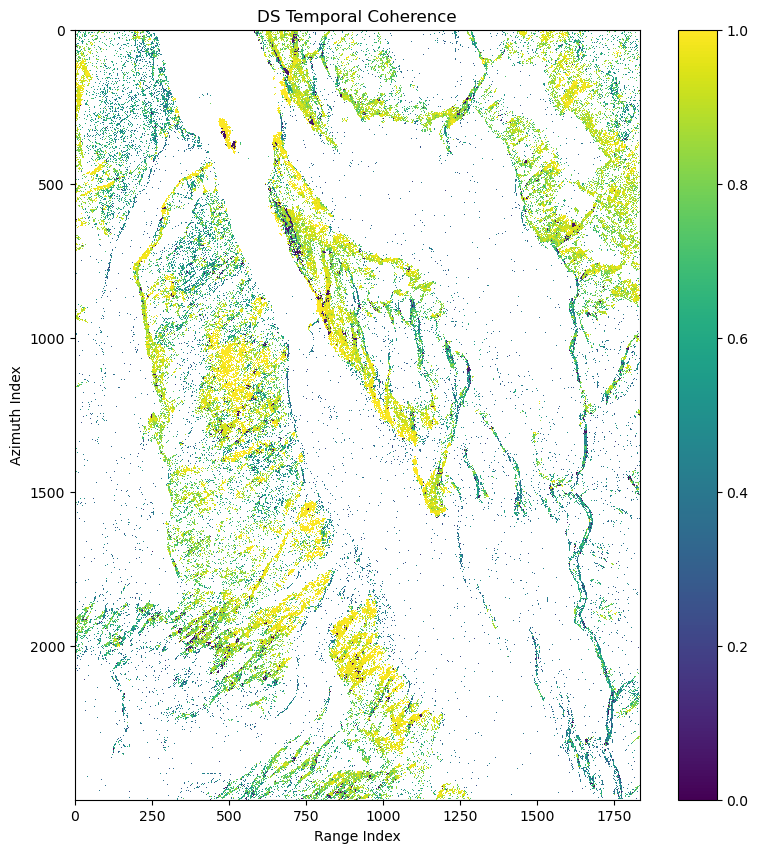

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
pcm = ax.imshow(ds_can_temp_coh_2d,interpolation='nearest',vmin=0.0,vmax=1.0)
ax.set(title='DS Temporal Coherence',xlabel='Range Index',ylabel='Azimuth Index')
fig.colorbar(pcm)
fig.show()

The example for raster data is the estimation of temporal coherence for selection of PS candidates with `n2f`:

In [ ]:
rslc = zarr.open('../CLI/raw/rslc.zarr/','r')[:]
intf = zarr.open('../CLI/dl/n2f_intf.zarr','r')[:]
image_pairs = mr.TempNet.from_bandwidth(rslc.shape[-1],1).image_pairs

In [ ]:
ps_temp_coh = temp_coh(intf,rslc,image_pairs)

or with gpu:

In [ ]:
rslc_cp = cp.asarray(rslc)
intf_cp = cp.asarray(intf)
ps_temp_coh_cp = temp_coh(intf_cp,rslc_cp,image_pairs)
ps_temp_coh = ps_temp_coh_cp.get()

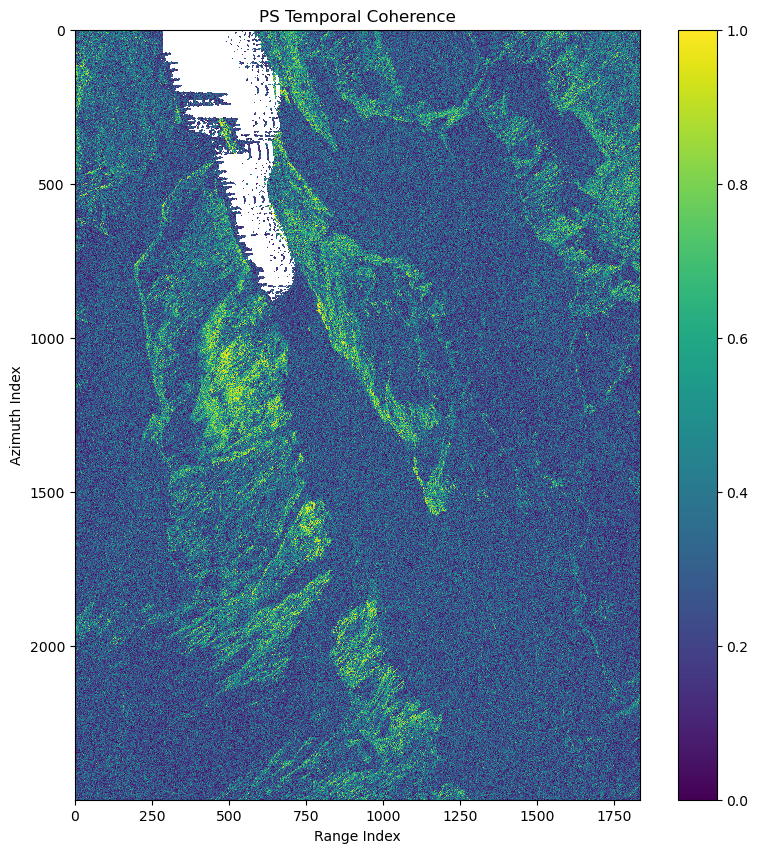

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
pcm = ax.imshow(ps_temp_coh,interpolation='nearest',vmin=0.0,vmax=1.0)
ax.set(title='PS Temporal Coherence',xlabel='Range Index',ylabel='Azimuth Index')
fig.colorbar(pcm)
fig.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()